In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
import argparse
import timeit
from collections import namedtuple
import warnings
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [15, 10]

In [ ]:
args = namedtuple('args', ['path', 'window', 'size', 'num', 'freq', 'order', 'growth_function', 'growth_cap', 'cut_off'])

In [ ]:
args.size = 6000
args.freq = 'min'
args.path = "../Data/filtered_sorted_data.csv"
args.window = 7
args.order = 30
args.num = 100
args.growth_function = 'linear'
args.growth_cap = 2.8
# args.starting_point = 9990
args.cut_off = 20000

In [ ]:
trainingfile = args.path
df = pd.read_csv(trainingfile)
df_log = df.copy()
df_log.y = df_log.y.apply(lambda x: np.log10(x))
if args.growth_function is 'logistic':
    print("HELP")
    df_log['cap'] = args.growth_cap

In [ ]:
results = pd.DataFrame()
# start_index = args.starting_point
end_index = args.cut_off
for count in range(0, args.num):
    start_time = timeit.default_timer()
    start_index = end_index - args.size
#     end_index = start_index + args.size
    print(start_index, end_index)
    assert(end_index - start_index == args.size)
    
    train_data = df_log[start_index: end_index]
    train_data = train_data.reset_index()
    model = Prophet(daily_seasonality=args.order, 
                    weekly_seasonality=args.order, 
                    growth=args.growth_function).fit(train_data)
    training_time = timeit.default_timer() - start_time
    
    start_time = timeit.default_timer()
    future = model.make_future_dataframe(periods=args.window, 
        freq=args.freq).tail(args.window)
    if args.growth_function is 'logistic':
        future['cap'] = args.growth_cap
    forecast=model.predict(future)
    inference_time = timeit.default_timer() - start_time
    last_estimate_index = args.window-1
    time_stamp = forecast.ds.iloc[last_estimate_index]
    yhat_log = forecast.yhat.iloc[last_estimate_index]
    yhat_upper_log = forecast.yhat_upper.iloc[last_estimate_index]
    yhat_lower_log = forecast.yhat_lower.iloc[last_estimate_index]
    yhat = 10 ** yhat_log
    yhat_upper = 10 ** yhat_upper_log
    yhat_lower = 10 ** yhat_lower_log
    true = df.y.iloc[end_index+last_estimate_index]
    true_log = df_log.y.iloc[end_index+last_estimate_index]
    error = np.abs(true - yhat)
    error_perc = np.divide(error, true)*100
    assert(forecast.ds.iloc[args.window-1] == pd.Timestamp(df_log.ds.iloc[end_index+args.window-1]))
    results = results.append({  'ds': time_stamp,  
                                'training_time': training_time,
                                'inference_time': inference_time,
                                'yhat_log': yhat_log,
                                'yhat_upper_log': yhat_upper_log,
                                'yhat_lower_log': yhat_lower_log,
                                'yhat': yhat,
                                'yhat_upper': yhat_upper,
                                'yhat_lower': yhat_lower,
                                'true_log': true_log,
                                'true': true,
                                'training_time': training_time,
                                'inference_time': inference_time,
                                'error': error,
                                'error_perc': error_perc
                                }, ignore_index=True)
    print(results[['ds', 'error_perc', 'training_time', 'inference_time', 'true', 'yhat']])
    end_index = end_index + 1
#     start_index = start_index + 1
results.to_csv('../Data/results.csv')

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
frames = [ pd.read_csv(f'../Data/results{count}.csv') for count in range(1,5)]
df_results = pd.concat(frames, ignore_index=True)

In [65]:
print(frames[0].ds.head())
print(frames[1].ds.head())

0    2013-01-05 04:06:00
1    2013-01-05 04:07:00
2    2013-01-05 04:08:00
3    2013-01-05 04:09:00
4    2013-01-05 04:10:00
Name: ds, dtype: object
0    2013-01-05 20:46:00
1    2013-01-05 20:47:00
2    2013-01-05 20:48:00
3    2013-01-05 20:49:00
4    2013-01-05 20:50:00
Name: ds, dtype: object


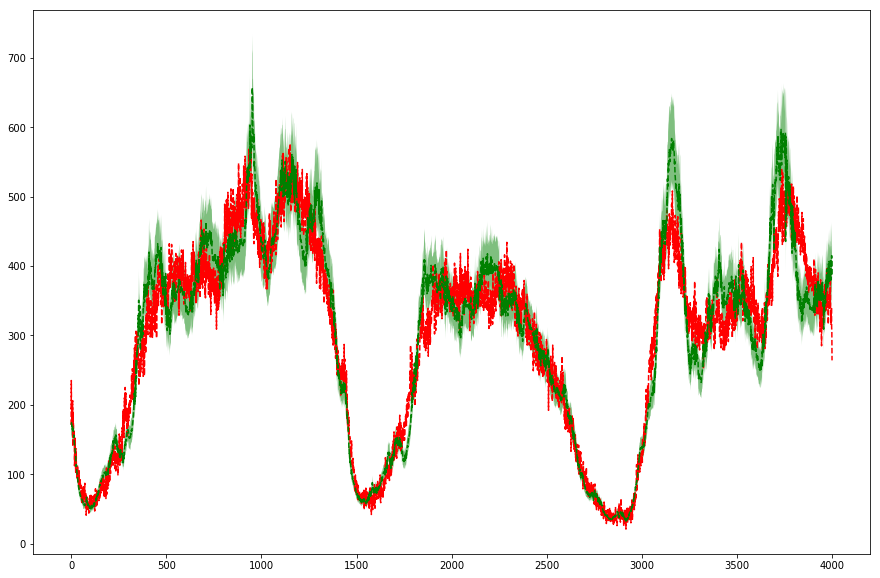

In [67]:
# df_results = pd.read_csv('../Data/results2.csv')
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(range(0,4000), df_results.true, 'r--', df_results.yhat, 'g--')
plt.fill_between(range(0,4000), df_results.yhat_upper, df_results.yhat_lower, facecolor='green', alpha=0.5)
# plt.scatter(range(0,30), results.yhat, 'r')

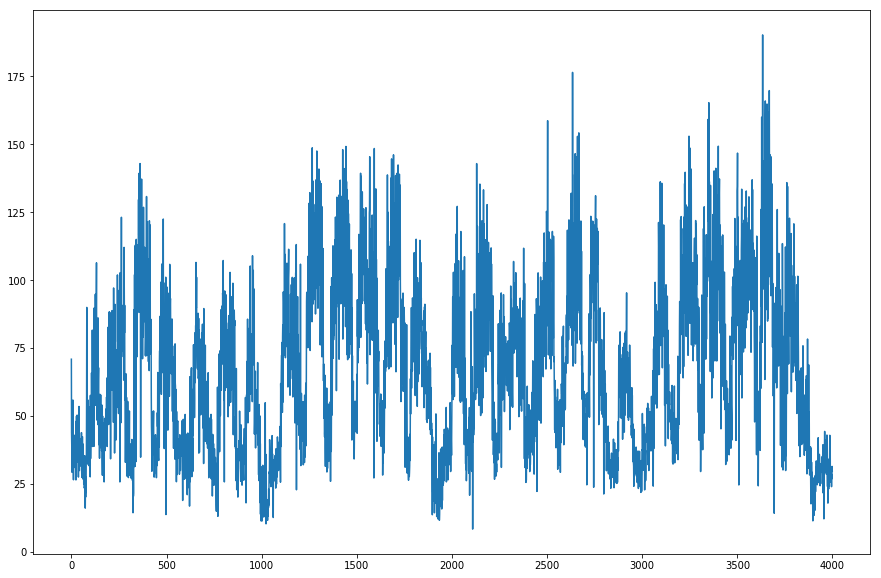

In [293]:
plt.plot(range(0,4000), df_results.training_time)

In [295]:
df_results.yhat

0       174.279389
1       174.405508
2       171.753253
3       172.042441
4       168.663413
5       170.190465
6       167.974584
7       163.938756
8       167.291700
9       168.580893
10      163.385491
11      165.237985
12      160.255336
13      156.322987
14      153.753919
15      155.431497
16      147.924855
17      145.001086
18      143.779921
19      140.095685
20      137.265160
21      132.632622
22      131.766534
23      129.735415
24      126.542736
25      119.434833
26      117.437548
27      111.337697
28      113.211127
29      106.662044
           ...    
3970    370.098975
3971    394.997317
3972    374.416138
3973    382.261472
3974    371.396382
3975    380.891961
3976    367.292242
3977    388.475286
3978    396.121460
3979    374.851530
3980    402.998348
3981    387.940918
3982    389.069208
3983    391.946314
3984    406.794251
3985    377.550724
3986    392.573373
3987    385.355436
3988    388.647102
3989    379.478819
3990    390.030750
3991    391.

In [288]:
d = pd.read_csv('../Data/filtered_sorted_data.csv', index_col='ds', nrows=6001)

In [289]:
d.tail()

,y
ds,
2013-01-05 03:56:00,187
2013-01-05 03:57:00,172
2013-01-05 03:58:00,172
2013-01-05 03:59:00,202
2013-01-05 04:00:00,187


In [183]:
mydict={'2013-01-01 00:00:00':10000, '2013-01-01 01:01:00':45}

In [184]:
ds = pd.Series(mydict, name='y')
ds.index.name = 'ds'

In [185]:
d1 = ds.to_frame()

In [186]:
d.y = d.y.apply(lambda x: np.log10(x))

In [187]:
d1.y = d1.y.apply(lambda x: np.log10(x))

In [283]:
try:
    d.append(d1, verify_integrity=True)
except ValueError:
    print('got duplicates')
    d = d.append(d1)
    d = d[~d.index.duplicated(keep='last')]
    d = d.sort_index()
d2 = d.copy()
d2 = d2.reset_index()
d

AttributeError: 'datetime.datetime' object has no attribute 'append'

In [282]:
d.tail()

AttributeError: 'datetime.datetime' object has no attribute 'tail'

In [203]:
int(d.iloc[d.index == '2013-01-01 00:01:00'].y)

118

In [222]:
import datetime

In [228]:
import datetime

date_time_str = '2018-06-29 08:15:27'  
date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

print('Date:', date_time_obj.date())  
print('Time:', date_time_obj.time())  
print('Date-time:', date_time_obj)  

Date: 2018-06-29
Time: 08:15:27
Date-time: 2018-06-29 08:15:27


In [231]:
from dateutil.parser import parse

d = parse('2018-06-29 08:15:27')

In [234]:
d = d + datetime.timedelta(minutes=1)

In [235]:
print(d)

2018-06-29 08:16:27


In [236]:
from datetime import timedelta

In [237]:
int('456')

456

In [238]:
int('{}')

ValueError: invalid literal for int() with base 10: '{}'

In [239]:
int('sdfgksjdf')

ValueError: invalid literal for int() with base 10: 'sdfgksjdf'

In [240]:
from requests import get

In [292]:
get("http://localhost:5002/", data={'cut_off':['2013-01-05 04:00:00']}).json()

{'timestamp': '2013-01-05 04:06:00',
 'yhat': 176.48400472285755,
 'yhat_upper': 197.75460197477565,
 'yhat_lower': 158.43471744069524,
 'training_time': 31.940611124038696,
 'inference_time': 1.7679870128631592}

In [291]:
get("http://localhost:5002/reset").json()

{}

In [254]:
def foo(a):
    a.add(1)
    
x = set(temp)
foo(x)
x

{1, '2013-01-01 00:01:00', '2013-01-01 00:02:00', '2013-01-01 00:03:00'}

In [255]:
from collections impo

In [257]:
import time

In [259]:
l =time.time()
time.sleep(70)
l1 =time.time()
print(l1-l)

70.00560927391052


In [260]:
print(time.time())
time.sleep(60)
print(time.time())

1541990225.607511
1541990285.6149418


In [275]:
from pprint import PrettyPrinter

In [281]:
pp = PrettyPrinter(depth=6, indent=3)
pp.pprint({'h':1, 'g':0})

{'g': 0, 'h': 1}


In [1]:
import scipy as sp

In [2]:
from scipy.stats import randint

In [3]:
import numpy as np

In [16]:
temp = np.random.randint(1,61, 6000000)

In [13]:
10000/60

166.66666666666666

In [6]:
import matplotlib.pyplot as plt

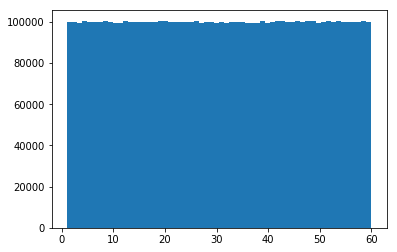

In [17]:
count, bins, ignored = plt.hist(temp, 60)
plt.show()

In [19]:
import seqdiag

In [20]:
seqdiag {
  browser  -> webserver [label = "GET /index.html"];
  browser <-- webserver;
  browser  -> webserver [label = "POST /blog/comment"];
              webserver  -> database [label = "INSERT comment"];
              webserver <-- database;
  browser <-- webserver;
}

SyntaxError: invalid syntax (<ipython-input-20-aa6de0a266fa>, line 1)

In [21]:
import pandas as pd

In [22]:
df = pd.read_csv('../Data/NYS_Thruway_Origin_and_Destination_Points_for_All_Vehicles_-_15_Minute_Intervals__Latest_Full_Week.csv')

In [25]:
df.columns

Index(['Date', 'Entrance', 'Exit', 'Interval Beginning Time', 'Vehicle Class',
       'Vehicle Count', 'Payment Type (Cash or E-ZPass)'],
      dtype='object')

In [38]:
g = df.groupby(['Date', 'Interval Beginning Time'])['Vehicle Count'].sum()

In [39]:
from matplotlib import pyplot as plt

In [97]:
df_ = pd.DataFrame(g).reset_index()

In [133]:
from datetime import datetime
def hrsec(row):
    hrs = int(np.floor(row['Interval Beginning Time']/100))
    minutes = int(np.floor(row['Interval Beginning Time']%100))
#     "21/11/06 16:30", "%d/%m/%y %H:%M"
    row.Date = datetime.strptime(row.Date + " " + str(hrs) + ":" + str(minutes), "%m/%d/%Y %H:%M")
    return row

In [147]:
from datetime import timedelta
from collections import Counter
dfm = df_.apply(hrsec, axis=1)
df_new = pd.DataFrame(columns=['ds', 'y'])
for index, row in dfm.iterrows():
    sample = np.random.randint(0,15, row['Vehicle Count'])
    sample_count = Counter(sample)
    for new_index in range(0,15):
#         print(row.Date + timedelta(minutes=new_index), sample_count[new_index])
        df_new = df_new.append({'ds':row.Date + timedelta(minutes=new_index), 'y':sample_count[new_index]}, ignore_index=True)
# df_new.reset_index()  


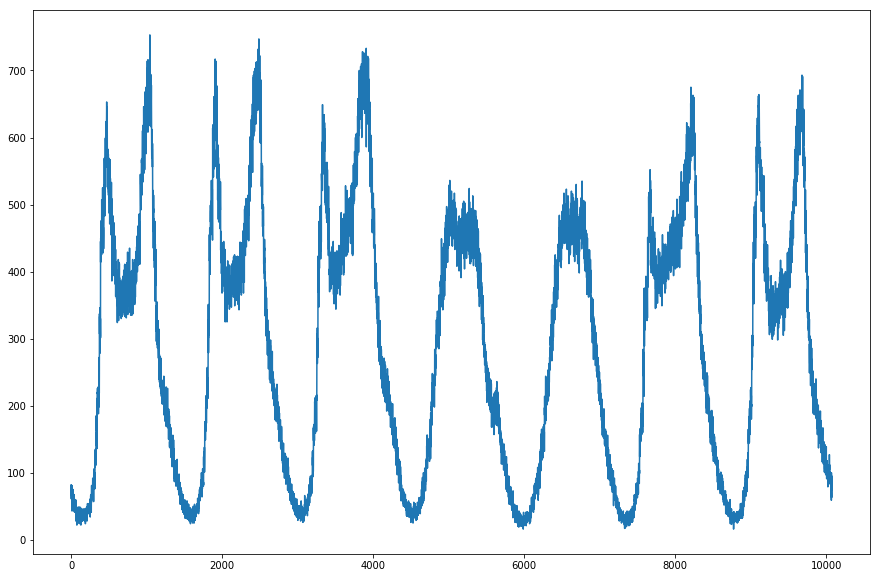

In [151]:
plt.rcParams['figure.figsize'] = [15, 10]
df_new.y.plot()

0         0
1        15
2        30
3        45
4       100
5       115
6       130
7       145
8       200
9       215
10      230
11      245
12      300
13      315
14      330
15      345
16      400
17      415
18      430
19      445
20      500
21      515
22      530
23      545
24      600
25      615
26      630
27      645
28      700
29      715
       ... 
642    1630
643    1645
644    1700
645    1715
646    1730
647    1745
648    1800
649    1815
650    1830
651    1845
652    1900
653    1915
654    1930
655    1945
656    2000
657    2015
658    2030
659    2045
660    2100
661    2115
662    2130
663    2145
664    2200
665    2215
666    2230
667    2245
668    2300
669    2315
670    2330
671    2345
Name: Interval Beginning Time, Length: 672, dtype: int64

In [152]:
from collections import deque

In [177]:
d = deque([0,0,0,0,0],maxlen=7)

In [182]:
d.append(6)

In [183]:
len(d)

7

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
frames = [ pd.read_csv(f'../Data/results{count}.csv') for count in range(1,5)]
df_results = pd.concat(frames, ignore_index=True)

In [200]:
from collections import deque
buffer = deque([], maxlen=5 )
df = pd.DataFrame(columns=['error-5', 'error-4', 'error-3', 'error-2', 'error-1', 'yhat', 'yhat_lower', 'yhat_upper'])
for index, row in df_results.iterrows():
    if len(buffer) >= 5:
        df=df.append({
                'error-5':buffer[0],
                'error-4':buffer[1],
                'error-3':buffer[2],
                'error-2':buffer[3],
                'error-1':buffer[4],
                'yhat'   :row['yhat'],
                'yhat_lower':row['yhat_lower'],
                'yhat_upper':row['yhat_upper'],
                'true': row['true']}, ignore_index=True)
    buffer.append((row['yhat'] - row['true'])/ row['true'])

,error-5,error-4,error-3,error-2,error-1,yhat,yhat_lower,yhat_upper,true
0,0.019178,-0.257849,-0.110087,-0.131099,-0.088306,170.190465,153.737047,189.548580,172.0
1,-0.257849,-0.110087,-0.131099,-0.088306,-0.010521,167.974584,150.791710,185.970625,183.0
2,-0.110087,-0.131099,-0.088306,-0.010521,-0.082106,163.938756,148.068210,182.777164,176.0
3,-0.131099,-0.088306,-0.010521,-0.082106,-0.068530,167.291700,150.035579,185.916199,206.0
4,-0.088306,-0.010521,-0.082106,-0.068530,-0.187904,168.580893,152.134566,187.620595,140.0


In [199]:
print(df_results.true[0:10])
print(df_results.error[0:10])

0    171.0
1    235.0
2    193.0
3    198.0
4    185.0
5    172.0
6    183.0
7    176.0
8    206.0
9    140.0
Name: true, dtype: float64
0     3.279389
1    60.594492
2    21.246747
3    25.957559
4    16.336587
5     1.809535
6    15.025416
7    12.061244
8    38.708300
9    28.580893
Name: error, dtype: float64


In [202]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_172"; Java(TM) SE Runtime Environment (build 1.8.0_172-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.172-b11, mixed mode)
  Starting server from /Users/ajaychhokra/Library/Python/3.6/lib/python/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/pj/y_vvxgw55sl6_0w5b1zz2b980000gn/T/tmpgvb7l_7a
  JVM stdout: /var/folders/pj/y_vvxgw55sl6_0w5b1zz2b980000gn/T/tmpgvb7l_7a/h2o_ajaychhokra_started_from_python.out
  JVM stderr: /var/folders/pj/y_vvxgw55sl6_0w5b1zz2b980000gn/T/tmpgvb7l_7a/h2o_ajaychhokra_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,25 days
H2O cluster name:,H2O_from_python_ajaychhokra_qitwb1
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [230]:
df = h2o.import_file('../Data/compensatorData.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [231]:
y='true'

In [232]:
aml2 = H2OAutoML(seed = 1, project_name = "BARISTA_COMPENSATOR", keep_cross_validation_predictions=True,sort_metric='mae', exclude_algos=['DeepLearning', 'GLM'])
aml2.train(y = y, training_frame = df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [263]:
test = h2o.import_file('../Data/compensatorDataTest.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [264]:
yhat_comp = aml2.leader.predict(test).as_data_frame()

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [265]:
test = test.as_data_frame()

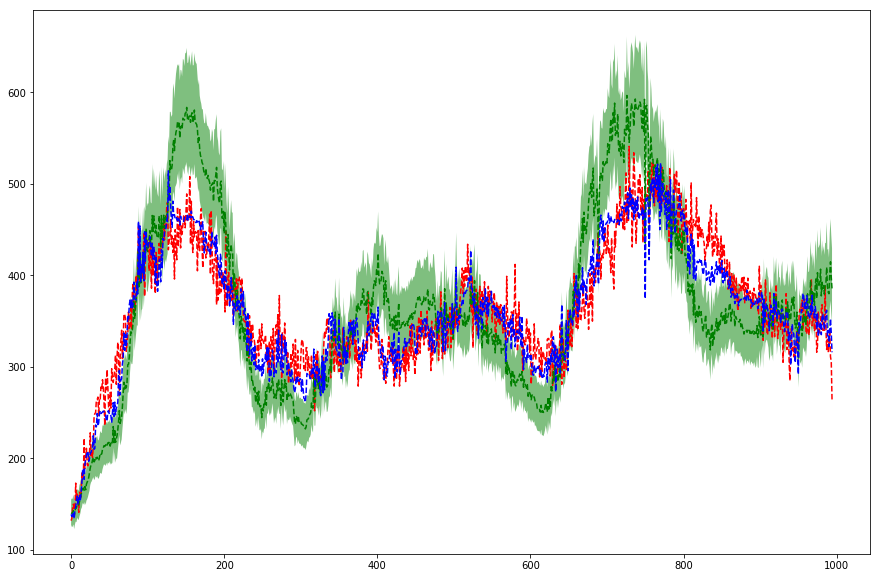

In [340]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(range(0,995), test['true'], 'r--', test['yhat'], 'g--', yhat_comp['predict'], 'b--')
plt.fill_between(range(0,995), test['yhat_upper'], test['yhat_lower'], facecolor='green', alpha=0.5)

In [288]:
test.columns

Index(['error-5', 'error-4', 'error-3', 'error-2', 'error-1', 'yhat',
       'yhat_lower', 'yhat_upper', 'true'],
      dtype='object')

5.10420810167
12.475994691
5.94053844241
13.4083302801


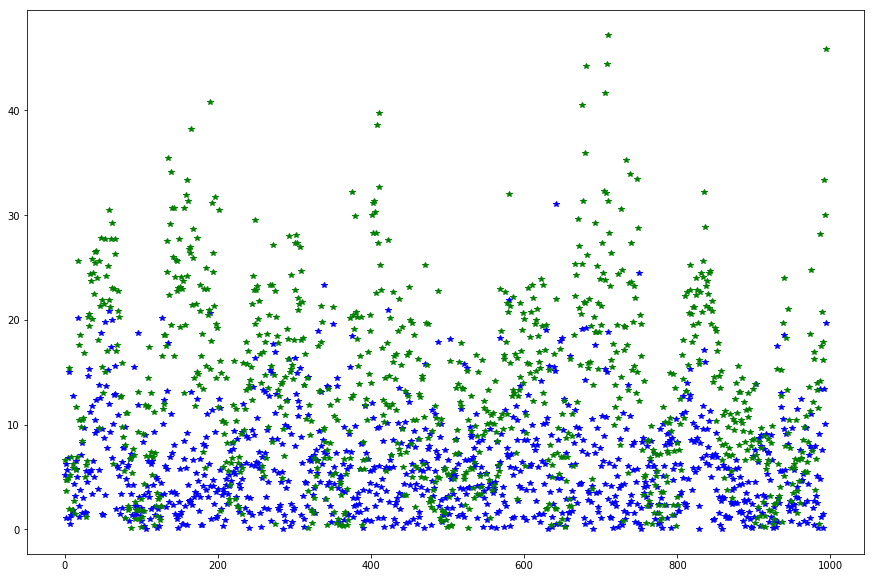

In [292]:
perc_error_comp = 100*abs(test.true - yhat_comp.predict)/test.true
perc_error = 100*abs(test.true - test.yhat)/test.true
print(np.percentile(perc_error_comp, 50))
print(np.percentile(perc_error, 50))
print(np.mean(perc_error_comp))
print(np.mean(perc_error))
plt.plot(range(0,995), perc_error_comp, 'b*', perc_error, 'g*')

In [293]:
from collections import Counter

In [302]:
perc_error_comp_rounded = map(round, perc_error_comp)
perc_error_rounded = map(round, perc_error)

In [303]:
results_comp = Counter(perc_error_comp_rounded)
results = Counter(perc_error_rounded)

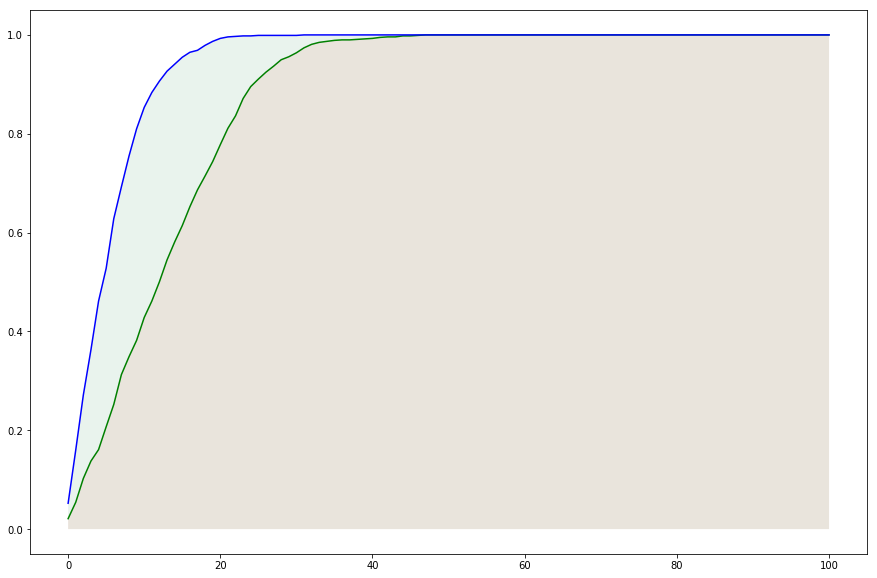

In [338]:
num_points = 995
mylist = []
mylist_comp = []
mysum = 0
mysum_comp = 0
for i in range(0,101):
    if i in results.keys():
        mysum = mysum + results[i]
    mylist.append(mysum/num_points)
    if i in results_comp.keys():
        mysum_comp = mysum_comp + results_comp[i]
    mylist_comp.append(mysum_comp/num_points)
plt.plot(range(0,101), mylist, 'g', mylist_comp, 'b')
plt.fill_between(range(0,101), [0]*101, mylist ,facecolor='tomato', alpha=0.1)
plt.fill_between(range(0,101), [0]*101, mylist_comp ,facecolor='seagreen', alpha=0.1)

In [310]:
[0]*100

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [328]:
frames = [ pd.read_csv(f'../Data/resultsNYCtoll{count}.csv') for count in range(2,4)]
df_results = pd.concat(frames, ignore_index=True)
df_results.to_csv('../Data/resultsNYCtoll.csv',index=False)

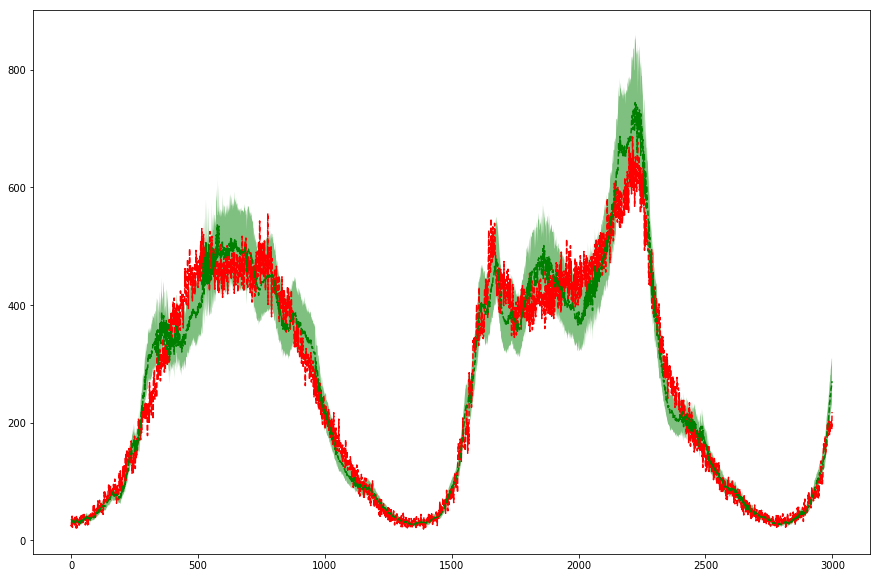

In [326]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(range(0,3000), df_results.true, 'r--', df_results.yhat, 'g--')
plt.fill_between(range(0,3000), df_results.yhat_upper, df_results.yhat_lower, facecolor='green', alpha=0.5)

In [332]:
np.percentile(df_results.error_perc, 95)

30.421843034918219

In [333]:
df_results.training_time.median()

11.769030392984861

In [341]:
h2o.shutdown()

[WARNING] in <ipython-input-341-1edf85295eae> line 1:
    >>> h2o.shutdown()
        ^^^^ Deprecated, use ``h2o.cluster().shutdown()``.
H2O session _sid_a0c6 closed.
